# Graph Transformer For Link Prediction on FB15k237 Dataset

In [ ]:
!pip uninstall torch -y
!pip install torch==2.4.0

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 12.0 MB/s eta 0:0

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['DGLBACKEND'] = "pytorch"

# Uncomment below to install required packages. If the CUDA version is not 11.8,
# check the https://www.dgl.ai/pages/start.html to find the supported CUDA
# version and corresponding command to install DGL.
#!pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html > /dev/null
#!pip install ogb >/dev/null

!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu121/repo.html
!pip install ogb

try:
    import dgl
    installed = True
except ImportError:
    installed = False
print("DGL installed!" if installed else "Failed to install DGL!")

Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.2/355.2 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.4 MB/s eta 0:00:00
DGL installed!


In [ ]:
!pip install rdflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 33.3 MB/s eta 0:00:00


In [ ]:
from dgl.data import FB15k237Dataset
import torch


# Load the dataset
dataset = FB15k237Dataset()
g = dataset[0]
print(g.edata.keys())

# Extract edge types
e_type = g.edata['etype']

# Get data splits
train_mask = g.edata['train_mask']
val_mask = g.edata['val_mask']
test_mask = g.edata['test_mask']

# Extract edges for training, validation, and testing
train_set = torch.arange(g.num_edges())[train_mask]
val_set = torch.arange(g.num_edges())[val_mask]
test_set = torch.arange(g.num_edges())[test_mask]

# Build train graph
train_edges = train_set
train_g = g.edge_subgraph(train_edges, relabel_nodes=False)
train_g.edata['etype'] = e_type[train_edges]

# Build validation graph (includes train + validation edges for message passing)
val_edges = torch.cat([train_edges, val_set])
val_g = g.edge_subgraph(val_edges, relabel_nodes=False)
val_g.edata['etype'] = e_type[val_edges]

# Build test graph (includes train + validation + test edges for message passing)
test_edges = torch.cat([val_edges, test_set])
test_g = g.edge_subgraph(test_edges, relabel_nodes=False)
test_g.edata['etype'] = e_type[test_edges]

# Print dataset statistics
print(f"Number of nodes: {g.num_nodes()}")
print(f"Number of edges: {g.num_edges()}")
print(f"Training edges: {train_g.num_edges()}")
print(f"Validation edges: {val_g.num_edges()}")
print(f"Test edges: {test_g.num_edges()}")





/root/.dgl/FB15k-237.tgz:   0%|          | 0.00/3.79M [00:00<?, ?B/s]

Extracting file to /root/.dgl/FB15k-237_40695531
# entities: 14541
# relations: 237
# training edges: 272115
# validation edges: 17535
# testing edges: 20466
Done saving data into cached files.
dict_keys(['train_edge_mask', 'valid_edge_mask', 'test_edge_mask', 'train_mask', 'val_mask', 'test_mask', 'etype'])
Number of nodes: 14541
Number of edges: 620232
Training edges: 544230
Validation edges: 579300
Test edges: 620232


## Multi-head Attention



In [ ]:
import dgl
import dgl.nn as dglnn
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from dgl.data import AsGraphPredDataset
from dgl.dataloading import GraphDataLoader
from ogb.graphproppred import collate_dgl, DglGraphPropPredDataset, Evaluator
from ogb.graphproppred.mol_encoder import AtomEncoder
from tqdm import tqdm

class MHA(nn.Module):
    def __init__(self, hidden_size=80, num_heads=8, num_rels=237*2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.num_rels = num_rels
        self.head_dim = hidden_size // num_heads
        self.scaling = self.head_dim**-0.5

        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)
        self.e_proj = nn.Linear(hidden_size, hidden_size)
        self.out_proj = nn.Linear(hidden_size, hidden_size)

        self.attention_weights = nn.Embedding(self.num_rels, self.num_heads)


    def forward(self, g, node_feats, edge_feats):
        src, dst = g.edges()
        edge_type = g.edata['etype']  # Relation types, including inverse relations

        # Project into multi-head space
        query = self.q_proj(node_feats[src]).view(-1, self.num_heads, self.head_dim)  # Shape: [num_edges, num_heads, head_dim]
        key = self.k_proj(node_feats[dst]).view(-1, self.num_heads, self.head_dim)    # Shape: [num_edges, num_heads, head_dim]
        value = self.v_proj(node_feats[dst]).view(-1, self.num_heads, self.head_dim)  # Shape: [num_edges, num_heads, head_dim]

        # Relation-specific attention weights
        relation_attn_weights = self.attention_weights(edge_type).unsqueeze(-1)  # Shape: [num_edges, num_heads, 1]

        # Compute attention scores
        raw_attention = (query * key).sum(dim=-1) * self.scaling  # Shape: [num_edges, num_heads]
        raw_attention = raw_attention + (relation_attn_weights * query).sum(dim=-1)  # Add relation-specific term

        attention = torch.softmax(raw_attention, dim=0)  # Normalize attention scores across edges
        attention = attention.unsqueeze(-1)  # Shape: [num_edges, num_heads, 1]

        # Weighted sum of values
        result = (attention * value).view(-1, self.hidden_size)  # Combine heads into original hidden size
        output = torch.zeros_like(node_feats).scatter_add_(
            0, src.unsqueeze(-1).expand_as(result), result
        )
        return self.out_proj(output)



## Graph Transformer Layer

In [ ]:
# Graph Transformer Layer
class GTLayer(nn.Module):
    def __init__(self, hidden_size=80, num_heads=8,num_rels=237*2):
        super().__init__()
        self.mha = MHA(hidden_size, num_heads, num_rels)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, 2 * hidden_size),
            nn.ReLU(),
            nn.Linear(2 * hidden_size, hidden_size),
        )
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)

    def forward(self, g, node_feats, edge_feats):
        h = self.norm1(node_feats + self.mha(g, node_feats, edge_feats))
        h = self.norm2(h + self.ffn(h))
        return h

## Graph Transformer Model

In [ ]:
def normalize_edge_features(edge_feats):
    return (edge_feats - edge_feats.mean(dim=0)) / (edge_feats.std(dim=0) + 1e-9)

class EdgeFeatureEnricher(nn.Module):
    def __init__(self, hidden_size, num_relations):
        super().__init__()
        self.num_relations = num_relations
        self.edge_embedding = nn.Embedding(num_relations, hidden_size)
        self.edge_linear = nn.Linear(hidden_size + 1, hidden_size)  # Scalar edge feature + embedding

    def forward(self, etype, edge_feats):
        # Embed edge types
        edge_embeds = self.edge_embedding(etype)

        # Concatenate edge embeddings with scalar edge features
        concatenated = torch.cat([edge_embeds, edge_feats.unsqueeze(-1)], dim=-1)

        # Transform enriched features
        enriched_feats = self.edge_linear(concatenated)

        # Normalize edge features
        normalized_feats = self.normalize_edges(enriched_feats)

        return normalized_feats

    def normalize_edges(self, edge_feats):
        # Normalize edge features by their L2 norm
        norms = edge_feats.norm(p=2, dim=-1, keepdim=True)
        return edge_feats / (norms + 1e-6)  # Avoid division by zero



In [ ]:
# Graph Transformer Model for Link Prediction
class GTModel(nn.Module):
    def __init__(self, num_nodes, num_rels, hidden_size=80, num_layers=4, num_heads=8, pos_enc_size=16,):
        super().__init__()
        self.node_embedding = nn.Embedding(num_nodes, hidden_size)
        self.edge_enricher = EdgeFeatureEnricher(hidden_size, num_rels)
        self.positional_linear = nn.Linear(pos_enc_size, hidden_size)  # Positional encoding to hidden size
        self.layers = nn.ModuleList(
            [GTLayer(hidden_size, num_heads, num_rels) for _ in range(num_layers)]
        )
        self.score_fn = nn.Sequential(
            nn.Linear(hidden_size * 3, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, g, triplets, pos_encodings):
        src, rel, dst = triplets[:, 0], triplets[:, 1], triplets[:, 2]
        node_feats = self.node_embedding.weight
        edge_feats = self.edge_enricher(g.edata['etype'],  g.edata['edge_scalar'])
        pos_enc_transformed = self.positional_linear(pos_encodings)
        node_feats = node_feats + pos_enc_transformed

        for layer in self.layers:
            node_feats = layer(g, node_feats, edge_feats)

        src_feats = node_feats[src]
        dst_feats = node_feats[dst]
        rel_feats = self.edge_enricher.edge_embedding(rel)

        # Concatenate src, dst, and relation embeddings for score prediction
        concat_feats = torch.cat([src_feats, rel_feats, dst_feats], dim=-1)
        return self.score_fn(concat_feats).squeeze(-1)



## Training

In [ ]:
def plot_loss_and_mae(train_losses, val_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)

    # Plot Losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.plot(epochs, test_losses, label='Test Loss', color='green')
    plt.title('Loss per Epoch (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MAE)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0.001, mode="max"):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_metric):
        if self.best_score is None:
            self.best_score = val_metric
            return False

        if self.mode == "max":
            # Metric should increase
            if val_metric > self.best_score + self.delta:
                self.best_score = val_metric
                self.counter = 0
            else:
                self.counter += 1
        elif self.mode == "min":
            # Metric should decrease
            if val_metric < self.best_score - self.delta:
                self.best_score = val_metric
                self.counter = 0
            else:
                self.counter += 1

        # Check if patience is exceeded
        if self.counter >= self.patience:
            self.early_stop = True

        return self.early_stop



In [ ]:
!pip install python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 87.5 MB/s eta 0:00:00


In [ ]:
import igraph as ig
import torch
from scipy.sparse import csr_matrix
import numpy as np
import igraph as ig

def compute_shortest_path_encoding_igraph(g, max_k):

    # Get edges in (source, target) format
    src, dst = g.edges()
    edges = list(zip(src.tolist(), dst.tolist()))

    # Convert DGL graph to igraph
    ig_graph = ig.Graph(edges=edges, directed=True)
    ig_graph.add_vertices(g.num_nodes() - ig_graph.vcount())

    # Compute pairwise shortest-path matrix
    sp_matrix = ig_graph.shortest_paths_dijkstra()

    # Convert pairwise shortest-path distances to a tensor
    sp_matrix = torch.tensor(sp_matrix, dtype=torch.float32)

    # Replace infinities with max_k (indicating no connection within max_k hops)
    sp_matrix[sp_matrix > max_k] = max_k

    # Compute node-wise shortest-path features
    min_dist = torch.min(sp_matrix, dim=1).values.unsqueeze(1)  # Shape: (num_nodes, 1)
    max_dist = torch.max(sp_matrix, dim=1).values.unsqueeze(1)  # Shape: (num_nodes, 1)
    mean_dist = torch.mean(sp_matrix, dim=1).unsqueeze(1)       # Shape: (num_nodes, 1)

    # Combine features
    sp_enc = torch.cat([min_dist, max_dist, mean_dist], dim=1)  # Shape: (num_nodes, 3)

    return sp_enc





In [ ]:
def compute_top_k_distances(g, max_k, k):

    # Get edges in (source, target) format
    src, dst = g.edges()
    edges = list(zip(src.tolist(), dst.tolist()))

    # Convert DGL graph to igraph
    ig_graph = ig.Graph(edges=edges, directed=True)
    ig_graph.add_vertices(g.num_nodes() - ig_graph.vcount())

    # Compute pairwise shortest-path matrix
    sp_matrix = ig_graph.shortest_paths_dijkstra()

    # Convert to PyTorch tensor
    sp_matrix = torch.tensor(sp_matrix, dtype=torch.float32)

    # Replace infinities with max_k + 1 to represent unreachable nodes
    unreachable_value = max_k + 1
    sp_matrix[sp_matrix == float('inf')] = unreachable_value

    # Sort distances for each node and extract top-k smallest distances
    # Exclude self-distance (0)
    sorted_distances, _ = torch.sort(sp_matrix, dim=1)
    top_k_distances = sorted_distances[:, 1:k + 1]  # Take top-k excluding the first value (self-loop)

    return top_k_distances


In [ ]:
def compute_rwpe(graph, num_rw_steps=5, k=10):

    # Extract adjacency matrix
    num_nodes = graph.num_nodes()
    adj_matrix = torch.zeros((num_nodes, num_nodes))
    src, dst = graph.edges()
    adj_matrix[src, dst] = 1  # Add edges to adjacency matrix

    # Normalize adjacency matrix row-wise (random walk probabilities)
    row_sums = adj_matrix.sum(dim=1, keepdim=True)
    transition_matrix = adj_matrix / (row_sums + 1e-9)  # Avoid division by zero

    # Compute RWPE
    rwpe = transition_matrix.clone()
    for _ in range(num_rw_steps - 1):
        rwpe = torch.matmul(rwpe, transition_matrix)  # Update visit probabilities

    top_k_values, _ = torch.topk(rwpe, k=k, dim=1)  # Select top-k values along rows
    return top_k_values


In [ ]:
def compute_relation(graph, num_iterations):

    num_nodes = graph.num_nodes()
    src, dst = graph.edges()
    etype = graph.edata['etype']

    # Initialize sparse adjacency matrices for each relation
    adj_matrices = {}
    for relation in torch.unique(etype):
        mask = etype == relation
        adj_matrices[relation.item()] = csr_matrix(
            (torch.ones(mask.sum()).numpy(), (src[mask].numpy(), dst[mask].numpy())),
            shape=(num_nodes, num_nodes)
        )

    # Initialize node labels as integers (convert to NumPy for vectorized operations)
    node_labels = np.arange(num_nodes)  # Use NumPy array for vectorized lookups

    # To store WL encodings
    wl_encodings = [node_labels.copy()]

    for _ in range(num_iterations):
        new_labels = []
        for node in range(num_nodes):
            # Aggregate neighbor labels from all relations
            aggregated_labels = []
            for relation, adj in adj_matrices.items():
                neighbors = adj[:, node].nonzero()[0].astype(int)  # Ensure integer indices
                neighbor_labels = node_labels[neighbors]  # Vectorized lookup
                aggregated_labels.extend([(label, relation) for label in neighbor_labels])

            # Hash aggregated labels to create a new label
            aggregated_labels = sorted(aggregated_labels)
            new_labels.append(hash((node_labels[node], tuple(aggregated_labels))))

        node_labels = np.array(new_labels)  # Convert back to NumPy array for compatibility
        wl_encodings.append(node_labels.copy())

    # Convert WL encodings to tensor
    wl_encodings = torch.tensor(np.array(wl_encodings), dtype=torch.float32).T
    return wl_encodings




In [ ]:
# Create a small multi-relational graph
src = torch.tensor([0, 0, 1, 2, 3, 3])  # Source nodes
dst = torch.tensor([1, 2, 3, 3, 4, 1])  # Destination nodes
etype = torch.tensor([0, 1, 0, 1, 0, 1])  # Edge types (relations)

# Create a DGL graph
g = dgl.graph((src, dst), num_nodes=5)
g.edata['etype'] = etype

# Print the graph details
print("Graph structure:")
print(g)
print("Edge data (relations):", g.edata['etype'])

Graph structure:
Graph(num_nodes=5, num_edges=6,
      ndata_schemes={}
      edata_schemes={'etype': Scheme(shape=(), dtype=torch.int64)})
Edge data (relations): tensor([0, 1, 0, 1, 0, 1])


In [ ]:
num_iterations = 2  # Test with 2 WL iterations
wl_encodings = compute_relation(g, num_iterations)

# Print the resulting WL encodings
print("WL Encodings for the small graph:")
print(wl_encodings)

WL Encodings for the small graph:
tensor([[ 0.0000e+00, -5.1910e+18,  3.2625e+18],
        [ 1.0000e+00, -6.6701e+17, -7.5443e+18],
        [ 2.0000e+00,  7.7266e+18, -1.5886e+18],
        [ 3.0000e+00, -4.6224e+18, -8.2865e+18],
        [ 4.0000e+00, -9.2006e+18, -5.1450e+16]])


In [ ]:
def prepare_positional_encodings(g, lap_dim=8, sp_max_k=5):

    # Compute Laplacian positional encodings
    lap_enc = dgl.laplacian_pe(g, k=lap_dim)

    # Compute shortest-path encodings
    #sp_enc = compute_shortest_path_encoding_igraph(g, max_k=sp_max_k)

    # Combine both encodings
    topk_enc = compute_top_k_distances(g, 100000, 10)
    combined_enc = torch.cat([lap_enc, topk_enc], dim=-1)

    return combined_enc


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import KMeans


def get_dominant_relation_per_node(g, num_rels=None):
    # Determine the actual number of relations in the graph
    if num_rels is None:
        num_rels = int(g.edata['etype'].max().item() + 1)

    # Initialize a matrix to count relations for each node
    relation_counts = torch.zeros(g.num_nodes(), num_rels, dtype=torch.int32)

    # Count the number of times each relation connects to each node
    src, dst = g.edges()
    for rel, s, d in zip(g.edata['etype'], src, dst):
        relation_counts[s, rel] += 1
        relation_counts[d, rel] += 1

    # Determine the dominant relation type for each node
    dominant_relations = relation_counts.argmax(dim=1)

    return dominant_relations.cpu().numpy()  # Convert to NumPy array for visualization


def cluster_entities(node_embeddings, num_clusters=10):

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(node_embeddings.cpu().numpy())
    return cluster_labels


def visualize_attention_scores_and_embeddings(model, g, device, color_by="relation", save_dir="visualizations"):
    # Create directory for saving plots if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    model.eval()
    with torch.no_grad():
        # Extract node embeddings
        node_embeddings = model.node_embedding.weight
        edge_feats = model.edge_enricher(g.edata['etype'], g.edata['edge_scalar']).to(device)

        if color_by == "relation":
            # Use the corrected function to get dominant relation types
            color_labels = get_dominant_relation_per_node(g)
            color_title = "Color-coded by Dominant Relation Type"
        elif color_by == "cluster":
            # Color nodes by clusters
            color_labels = cluster_entities(node_embeddings, num_clusters=10)
            color_title = "Color-coded by Clusters"
        else:
            raise ValueError("Invalid color_by value. Choose 'relation' or 'cluster'.")

        # PCA for Node Embeddings
        pca = PCA(n_components=2)
        node_pca = pca.fit_transform(node_embeddings.cpu().numpy())

        # t-SNE for Node Embeddings
        tsne = TSNE(n_components=2, random_state=42)
        node_tsne = tsne.fit_transform(node_embeddings.cpu().numpy())

        # Visualization of PCA and t-SNE with color-coding
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        scatter_pca = plt.scatter(
            node_pca[:, 0], node_pca[:, 1], c=color_labels, cmap="tab10", alpha=0.7
        )
        plt.colorbar(scatter_pca, label="Category")
        plt.title(f"PCA of Node Embeddings ({color_title})")
        plt.xlabel("PCA1")
        plt.ylabel("PCA2")
        plt.savefig(os.path.join(save_dir, "node_embeddings_pca.png"))

        plt.subplot(1, 2, 2)
        scatter_tsne = plt.scatter(
            node_tsne[:, 0], node_tsne[:, 1], c=color_labels, cmap="tab10", alpha=0.7
        )
        plt.colorbar(scatter_tsne, label="Category")
        plt.title(f"t-SNE of Node Embeddings ({color_title})")
        plt.xlabel("t-SNE1")
        plt.ylabel("t-SNE2")
        plt.savefig(os.path.join(save_dir, "node_embeddings_tsne.png"))

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, "node_embeddings_pca_tsne_combined.png"))  # Save combined PCA + t-SNE
        plt.show()

        # Visualize Attention Scores
        try:
            attention_scores = edge_feats.cpu().numpy().flatten()
            plt.figure(figsize=(8, 6))
            plt.hist(attention_scores, bins=50, color="blue", alpha=0.7)
            plt.title("Distribution of Attention Scores")
            plt.xlabel("Attention Score")
            plt.ylabel("Frequency")
            plt.savefig(os.path.join(save_dir, "attention_scores_distribution.png"))
            plt.show()
        except Exception as e:
            print(f"Could not visualize attention scores: {e}")



In [ ]:
def calculate_hits_and_mrr(model, g, triplets,pos_enc, device, k_list=[1, 3, 10], batch_size=1024, num_negatives=50):
    model.eval()
    num_samples = len(triplets)
    hits = {k: 0 for k in k_list}
    mrr = 0.0

    with torch.no_grad():
        for i in range(0, num_samples, batch_size):
            batch_triplets = triplets[i:i+batch_size].to(device)
            pos_scores = model(g, batch_triplets, pos_enc)  # Shape: [batch_size]

            # Negative sampling
            neg_triplets = negative_sampling(batch_triplets, g.num_nodes(), device, num_negatives=num_negatives)
            neg_scores = model(g, neg_triplets, pos_enc)  # Shape: [batch_size * num_negatives]

            # Reshape neg_scores to [batch_size, num_negatives]
            neg_scores = neg_scores.view(batch_triplets.size(0), num_negatives)

            # Concatenate scores for ranking
            all_scores = torch.cat([pos_scores.unsqueeze(1), neg_scores], dim=1)  # Shape: [batch_size, num_negatives + 1]

            # Calculate ranks
            ranks = (all_scores >= pos_scores.unsqueeze(1)).sum(dim=1)  # Rank of positive sample
            mrr += (1.0 / ranks.float()).sum().item()

            # Calculate hits@k
            for k in k_list:
                hits[k] += (ranks <= k).sum().item()

    num_batches = (num_samples + batch_size - 1) // batch_size
    mrr /= num_samples
    for k in k_list:
        hits[k] /= num_samples
    print(f"Hits@k: {hits}")
    print(f"MRR: {mrr}")

    return hits, mrr



In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.metrics import roc_auc_score

# Load FB15k237 dataset
dataset = FB15k237Dataset(reverse=False)
g = dataset[0]
# Define dimensions for positional encodings
lap_dim = 8  # Number of dimensions for Laplacian positional encoding
sp_max_k = 5  # Maximum shortest-path distance
g.ndata['pos_enc'] = compute_relation(g, 2)
num_nodes = g.num_nodes()
num_rels = dataset.num_rels

# Masks for splits
train_mask = g.edata['train_mask']
val_mask = g.edata['val_mask']
test_mask = g.edata['test_mask']

# Extract triplets using masks
train_idx = train_mask.nonzero(as_tuple=False).squeeze()
val_idx = val_mask.nonzero(as_tuple=False).squeeze()
test_idx = test_mask.nonzero(as_tuple=False).squeeze()

src, dst = g.edges()
etype = g.edata['etype']

train_triplets = torch.stack([src[train_idx], etype[train_idx], dst[train_idx]], dim=1)
val_triplets = torch.stack([src[val_idx], etype[val_idx], dst[val_idx]], dim=1)
test_triplets = torch.stack([src[test_idx], etype[test_idx], dst[test_idx]], dim=1)

print("Training triplets:", train_triplets.shape)
print("Validation triplets:", val_triplets.shape)
print("Testing triplets:", test_triplets.shape)

# entities: 14541
# relations: 237
# training edges: 272115
# validation edges: 17535
# testing edges: 20466
Done loading data from cached files.
Training triplets: torch.Size([544230, 3])
Validation triplets: torch.Size([35070, 3])
Testing triplets: torch.Size([40932, 3])


In [ ]:
import matplotlib.pyplot as plt
import os

def plot_metrics(metrics, save_dir='metrics_plots'):

    os.makedirs(save_dir, exist_ok=True)

    epochs = range(1, len(metrics['train_loss']) + 1)

    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(metrics['train_loss'])), metrics['train_loss'][1:], label='Training Loss', color='blue')
    plt.plot(range(1, len(metrics['train_loss'])), metrics['val_loss'][1:], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'training_validation_loss.png'))

    # Plot Validation AUC
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics['val_auc'], label='Validation AUC', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title('Validation AUC')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'validation_auc.png'))

    # Plot Validation MRR
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics['val_mrr'], label='Validation MRR', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('MRR')
    plt.title('Validation MRR')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'validation_mrr.png'))

    # Plot Hits@k
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics['val_hits@1'], label='Hits@1', color='red')
    plt.plot(epochs, metrics['val_hits@3'], label='Hits@3', color='orange')
    plt.plot(epochs, metrics['val_hits@10'], label='Hits@10', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Hits@k')
    plt.title('Validation Hits@k')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'validation_hits_at_k.png'))

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'combined_metrics.png'))
    plt.show()


In [ ]:
print(f"Positional encoding shape: {g.ndata['pos_enc'].shape}")

Positional encoding shape: torch.Size([14541, 3])


In [ ]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GTModel(num_nodes, num_rels*2, pos_enc_size=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
# Compute the class imbalance ratio
pos_count = len(train_triplets)
neg_count = num_nodes * num_nodes * num_rels - pos_count  # Approximate negatives

# Calculate the positive weight
pos_weight = neg_count / pos_count

# Define the weighted BCE loss function
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))


g = g.to(device)
g.edata['etype'] = g.edata['etype'].to(device)
g.edata['edge_scalar'] = torch.ones(g.num_edges(), dtype=torch.float32, device=device)
g.ndata[dgl.NID] = torch.arange(g.num_nodes()).to(device)

pos_enc = g.ndata['pos_enc'].to(device)

def negative_sampling(pos_triplets, num_nodes, device, num_negatives=5):
    # Generate negative samples on the specified device
    neg_src = torch.randint(0, num_nodes, (len(pos_triplets) * num_negatives,), device=device)
    neg_dst = torch.randint(0, num_nodes, (len(pos_triplets) * num_negatives,), device=device)
    neg_rel = pos_triplets[:, 1].repeat(num_negatives).to(device)  # Use the same relation
    return torch.stack([neg_src, neg_rel, neg_dst], dim=1)





def train_with_validation_and_logging(model, g, train_triplets, val_triplets, optimizer, device, num_epochs=20, batch_size=1024):
    model.train()
    num_train_samples = len(train_triplets)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=2, threshold=0.001, verbose=True
)
    early_stopping = EarlyStopping(patience=5, delta=0.001, mode="max")
    pos_enc = g.ndata['pos_enc'].to(device)

    # Variables to track the best model and metrics
    best_mrr = 0.0
    best_model_path = "best_model.pth"

    metrics = {
        'train_loss': [],
        'val_loss': [],
        'val_auc': [],
        'val_mrr': [],
        'val_hits@1': [],
        'val_hits@3': [],
        'val_hits@10': []
    }

    hits_at_k, mrr = calculate_hits_and_mrr(model, g, val_triplets, pos_enc, device)
    print(hits_at_k, mrr)
    for epoch in range(num_epochs):
        # Shuffle the training triplets
        perm = torch.randperm(num_train_samples)
        train_triplets = train_triplets[perm]

        total_loss = 0.0
        num_batches = (num_train_samples + batch_size - 1) // batch_size

        for i in range(0, num_train_samples, batch_size):
            batch_triplets = train_triplets[i:i+batch_size].to(device)

            # Forward pass
            pos_scores = model(g, batch_triplets, pos_enc)

            neg_triplets = negative_sampling(batch_triplets, g.num_nodes(), device)
            neg_scores = model(g, neg_triplets, pos_enc)

            labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)])
            scores = torch.cat([pos_scores, neg_scores])

            loss = loss_fn(scores, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / num_batches
        metrics['train_loss'].append(avg_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss, val_auc = evaluate(model, g, val_triplets, pos_enc, device)
            hits_at_k, mrr = calculate_hits_and_mrr(model, g, val_triplets, pos_enc, device)

            # Log metrics
            metrics['val_loss'].append(val_loss)
            metrics['val_auc'].append(val_auc)
            metrics['val_mrr'].append(mrr)
            metrics['val_hits@1'].append(hits_at_k[1])
            metrics['val_hits@3'].append(hits_at_k[3])
            metrics['val_hits@10'].append(hits_at_k[10])

            # Save the best model based on MRR
            if mrr > best_mrr:
                best_mrr = mrr
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_mrr': best_mrr,
                }, best_model_path)
                print(f"Best model saved at epoch {epoch + 1} with MRR: {best_mrr:.4f}")

            scheduler.step(mrr)

            # Early stopping
            if early_stopping(mrr):
                print(f"Early stopping at epoch {epoch+1}")
                break

            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Validation AUC: {val_auc:.4f}, Validation Loss: {val_loss:.4f}")

        print(
            f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, "
            f"Validation AUC: {val_auc:.4f}, "
            f"MRR: {mrr:.4f}, Hits@1: {hits_at_k[1]:.4f}, Hits@3: {hits_at_k[3]:.4f}, Hits@10: {hits_at_k[10]:.4f}"
        )

        model.train()

    return metrics



def evaluate(model, g, triplets, pos_enc, device):
    model.eval()
    with torch.no_grad():
        pos_triplets = triplets.to(device)
        pos_scores = model(g, pos_triplets, pos_enc)

        neg_triplets = negative_sampling(pos_triplets, g.num_nodes(), device)
        neg_scores = model(g, neg_triplets, pos_enc)

        scores = torch.cat([pos_scores, neg_scores]).to(device)
        labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)]).to(device)

        loss = loss_fn(scores, labels).item()

        # Calculate AUC
        auc = roc_auc_score(labels.cpu().numpy(), scores.cpu().numpy())


        return loss, auc

def calculate_mrr_hits_for_test(model, g, triplets,pos_enc, device):
    model.eval()
    with torch.no_grad():
        pos_enc = g.ndata['pos_enc'].to(device)
        hits_at_k, mrr = calculate_hits_and_mrr(model, g, triplets,pos_enc, device)
    return hits_at_k, mrr


# Train with validation and evaluate on test set
metrics= train_with_validation_and_logging(model, g, train_triplets, val_triplets, optimizer, device, num_epochs=10, batch_size=1024)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Hits@k: {1: 0.06658112346735101, 3: 0.12158540062731679, 10: 0.3027658967778728}
MRR: 0.1433760357746073
{1: 0.06658112346735101, 3: 0.12158540062731679, 10: 0.3027658967778728} 0.1433760357746073
Hits@k: {1: 0.28212147134302823, 3: 0.3198745366410037, 10: 0.37499287140005705}
MRR: 0.3269493012745087
Best model saved at epoch 1 with MRR: 0.3269
Epoch 1/10, Loss: 151.6022, Validation AUC: 0.5026, Validation Loss: 9.1588
Epoch 1/10, Loss: 151.6022, Validation AUC: 0.5026, MRR: 0.3269, Hits@1: 0.2821, Hits@3: 0.3199, Hits@10: 0.3750
Hits@k: {1: 0.2813800969489592, 3: 0.31551183347590533, 10: 0.3743085258055318}
MRR: 0.3252866051018255
Epoch 2/10, Loss: 9.8686, Validation AUC: 0.5046, Validation Loss: 9.1643
Epoch 2/10, Loss: 9.8686, Validation AUC: 0.5046, MRR: 0.3253, Hits@1: 0.2814, Hits@3: 0.3155, Hits@10: 0.3743
Hits@k: {1: 0.27547761619617905, 3: 0.31505560307955516, 10: 0.38768177929854575}
MRR: 0.32349298105710317
Epoch 3/10, Loss: 9.7385, Validation AUC: 0.5077, Validation Loss: 9

In [ ]:
# Load the best model
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_epoch = checkpoint['epoch']
best_mrr = checkpoint['best_mrr']

print(f"Loaded best model from epoch {best_epoch} with MRR: {best_mrr:.4f}")

# Evaluate on the test set
test_loss, test_auc = evaluate(model, g, test_triplets, pos_enc, device)
hits_at_k, mrr = calculate_mrr_hits_for_test(model, g, test_triplets, pos_enc, device)

print(f"Test AUC: {test_auc:.4f}")
print(
    f"Test MRR: {mrr:.4f}, "
    f"Hits@1: {hits_at_k[1]:.4f}, Hits@3: {hits_at_k[3]:.4f}, Hits@10: {hits_at_k[10]:.4f}"
)


Loaded best model from epoch 8 with MRR: 0.4681


<ipython-input-46-3bd1eea2f36b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth")


Hits@k: {1: 0.30465161731652496, 3: 0.5584139548519496, 10: 0.7696423336265025}
MRR: 0.4645643149444601
Test AUC: 0.8348
Test MRR: 0.4646, Hits@1: 0.3047, Hits@3: 0.5584, Hits@10: 0.7696


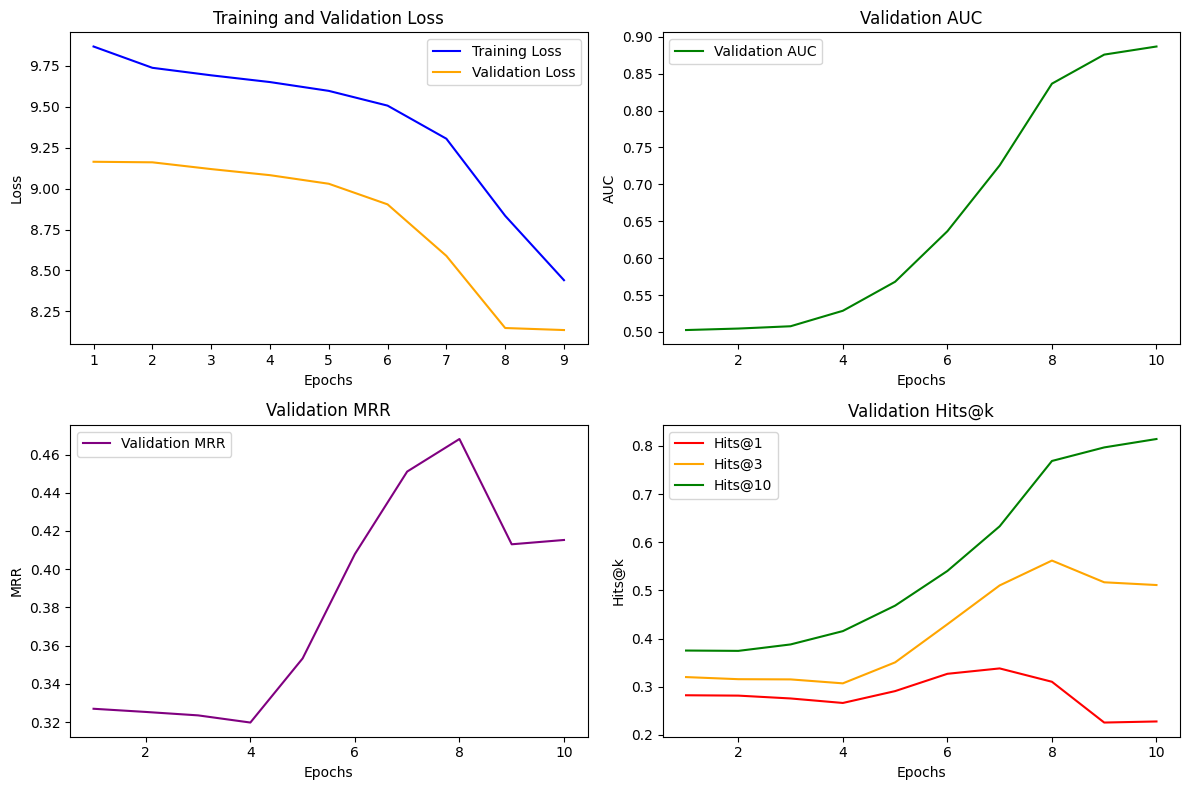

In [ ]:
plot_metrics(metrics)

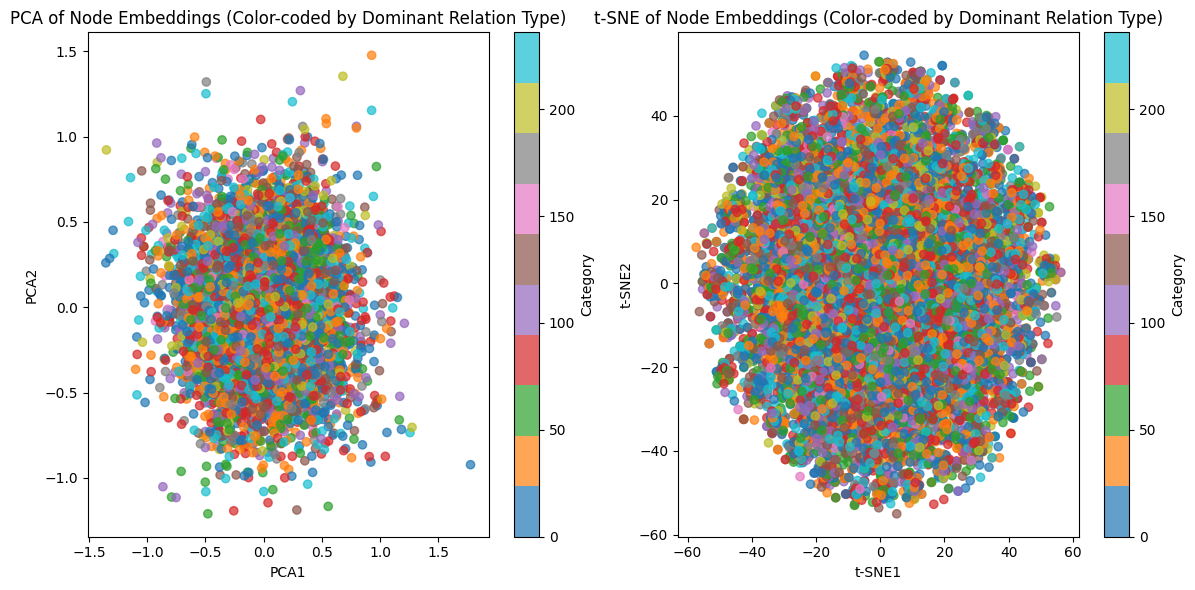

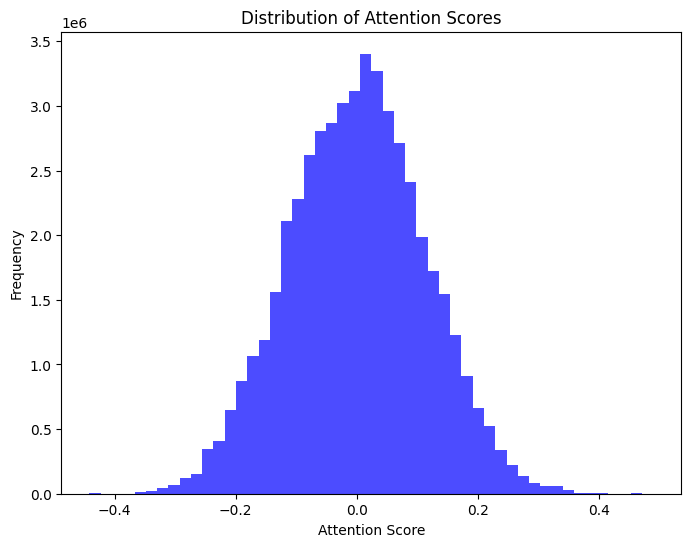

In [ ]:
visualize_attention_scores_and_embeddings(model, g, device)